## Signal-Like tritium training data


1. Exclude S2-only events
2. S1 vs S2 uncorrected area - make a box cut around tritium data
<br> Cut low S1 area population,handscan using eventviewer
4. Drift time against S2_x_cm^2 + S2_y_cm^2 cut 
5. Apply 2 and 3 on Bad area vs S2 corrected area plot
6. Threshold Cut: 1D histogram of s2-area. lower threshold cut, upper threshold cut = 50 electrons
<br> Do this for both:
<br> - S2 only events (hence dont apply drift cuts)
<br> - No S2 only events

In [59]:
import uproot
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from scipy.optimize import curve_fit
import os

%matplotlib notebook

In [60]:
os.chdir(r"C:\Users\hpetr\Documents\University\Year 3\Bsc Project\Data")

#1. exclude S2-only events 
with uproot.open("ch3t_sr1_fixed.root") as f:
    arr = f["Events"].arrays(cut = 'S1_corrected_area > 0', library = 'pd')
arr.head()

,runID,evtID,S2_area,S2_btm_area,S2_top_area,S2_TBA,S2_corrected_area,S2_XY_corrected_area,S2_width_ns,S2_peakAmp,...,S2_n_saturated,has_good_S1,drift_time,S1_area,S1_corrected_area,evt_total_area,evt_bad_area,evt_bad_e_area,evt_bad_ph_area,evt_bad_oth_area
0,8136,65034,118.0,49.244331,4.825457e+01,-0.010151,9.870134e+01,0.002266,2870.0,0.158147,...,0.0,True,1880.00000,2295.077637,2384.228760,2.669723e+03,277.044191,2.625722e+02,112.073274,2.121996e-314
1,8136,65058,742.0,131640.343750,2.982435e+05,0.387554,3.297500e+06,15.089437,5360.0,298.280945,...,0.0,True,331150.03125,5893.939453,5994.260742,5.819314e+05,150035.855259,5.793474e+05,528.764211,4.347748e+01
2,8136,65060,552.0,677225.187500,1.202335e+06,0.279379,3.297500e+06,67.300720,9060.0,1371.740112,...,3.0,True,331150.03125,5893.939453,5994.260742,2.781278e+06,896683.535831,2.774540e+06,474.216490,1.230250e+03
3,8136,65063,806.0,101785.929688,2.272925e+05,0.381388,2.183503e+06,11.366468,3960.0,220.868744,...,0.0,True,23620.00000,2942.413818,3231.704346,5.545283e+05,223988.855204,5.524404e+05,567.587461,5.960238e+01
4,8136,65070,640.0,197790.750000,4.263606e+05,0.366209,6.481201e+05,20.348724,4140.0,459.318115,...,0.0,True,9920.00000,1746.073730,1825.996216,6.835850e+05,57687.135598,6.813085e+05,438.078742,9.228541e+01


<IPython.core.display.Javascript object>


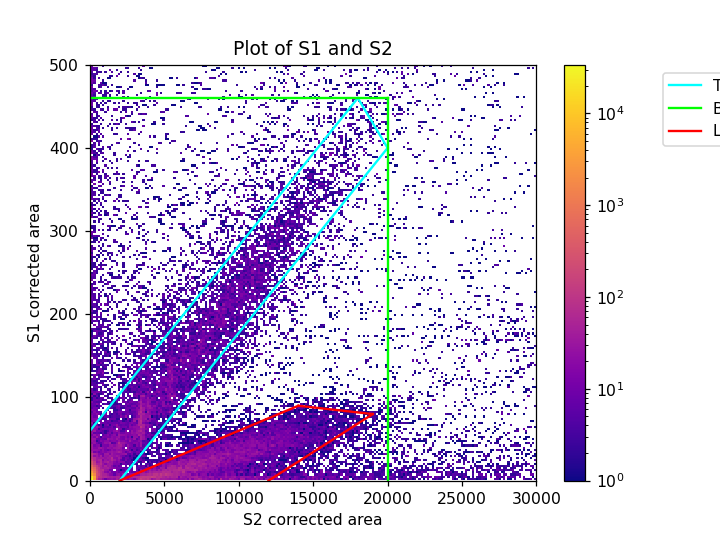

In [61]:
fig, ax = plt.subplots()
conditions= (arr['S1_corrected_area']<500) & (arr['S2_corrected_area']<30000)

#Tight cut
line1 = plt.Line2D((2000, 20000), (0, 400), color = 'cyan', label="Tight cut")
line2 = plt.Line2D((0, 18000), (60, 460), color = 'cyan')
line3 = plt.Line2D((20000, 18000), (400, 460), color = 'cyan')

#Box cut
line4=plt.Line2D((0,20000),(460,460), color="lime", label = "Box cut")
line5 = plt.Line2D((20000, 20000), (460, 0), color = 'lime')

#Low S1 population
line6=plt.Line2D((2000,14000),(0,90), color="red", label = "Low S1 population")
line7 = plt.Line2D((12000, 19000), (0,80), color = 'red')
line8 = plt.Line2D((14000, 19000), (90,80), color = 'red')


#Plot
h = ax.hist2d(arr['S2_corrected_area'].to_numpy()[conditions], 
              arr['S1_corrected_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

ax.add_line(line1)
ax.add_line(line2)
ax.add_line(line3)

ax.add_line(line4)
ax.add_line(line5)

ax.add_line(line6)
ax.add_line(line7)
ax.add_line(line8)

plt.ylim(0, 500)
plt.xlim(0, 30000)
plt.xlabel('S2 corrected area')
plt.ylabel('S1 corrected area')
plt.title('Plot of S1 and S2')
plt.legend(loc='upper right',bbox_to_anchor=(1.75, 1))
plt.show()

#for line1
m = 400 / 18000
c1 = -40 

#for line2
m = 400 / 18000
c2 = 60 


#box cut around this
#plot negative drift time vs radius^2 (from x^2 + y^of 2 of S2)

<IPython.core.display.Javascript object>


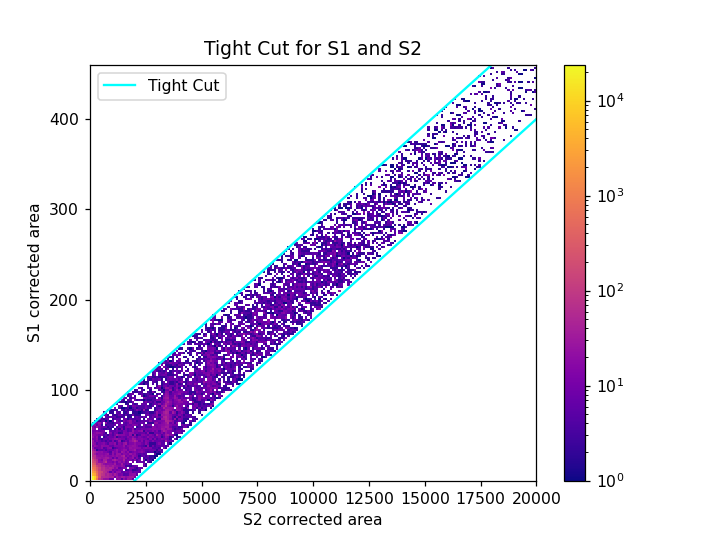

<IPython.core.display.Javascript object>


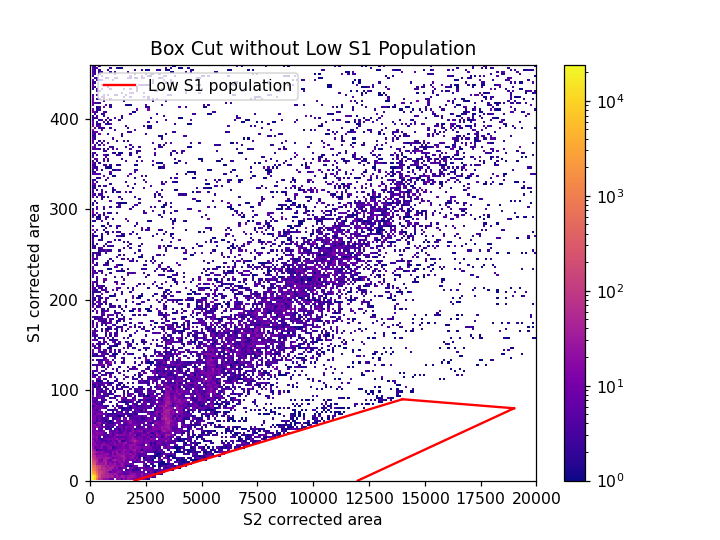

In [62]:
def line(x, m, c):
    y = (m * x) + c
    return y

#Tight cut
fig, ax = plt.subplots()
conditions = (arr['S1_corrected_area']<line(arr['S2_corrected_area'], m, c2)) & (arr['S1_corrected_area']>line(arr['S2_corrected_area'], m, c1))  & (arr['S2_corrected_area']< 20000) &(arr['S1_corrected_area']<460) 


line1 = plt.Line2D((2000, 20000), (0, 400), color = 'cyan', label="Tight Cut")
line2 = plt.Line2D((0, 18000), (60, 460), color = 'cyan')
#line3 = plt.Line2D((20000, 18000), (400, 460), color = 'cyan')

h = ax.hist2d(arr['S2_corrected_area'].to_numpy()[conditions], 
              arr['S1_corrected_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)
ax.add_line(line1)
ax.add_line(line2)
#ax.add_line(line3)
plt.xlabel('S2 corrected area')
plt.ylabel('S1 corrected area')
plt.title('Tight Cut for S1 and S2')
plt.ylim(0, 460)
plt.xlim(0, 20000)
plt.legend()
plt.show()

#3. Cut low S1 area population
fig, ax = plt.subplots()
conditions = (arr['S1_corrected_area']>line(arr['S2_corrected_area'], 0.008, -18)) & (arr['S2_corrected_area']< 20000) &(arr['S1_corrected_area']<460)


line6=plt.Line2D((2000,14000),(0,90), color="red", label = "Low S1 population")
line7 = plt.Line2D((12000, 19000), (0,80), color = 'red')
line8 = plt.Line2D((14000, 19000), (90,80), color = 'red')

h = ax.hist2d(arr['S2_corrected_area'].to_numpy()[conditions], 
              arr['S1_corrected_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 corrected area')
plt.ylabel('S1 corrected area')
plt.title('Box Cut without Low S1 Population')
plt.ylim(0, 460)
plt.xlim(0, 20000)
ax.add_line(line6)
ax.add_line(line7)
ax.add_line(line8)
plt.legend(loc="upper left")
plt.show()

<IPython.core.display.Javascript object>


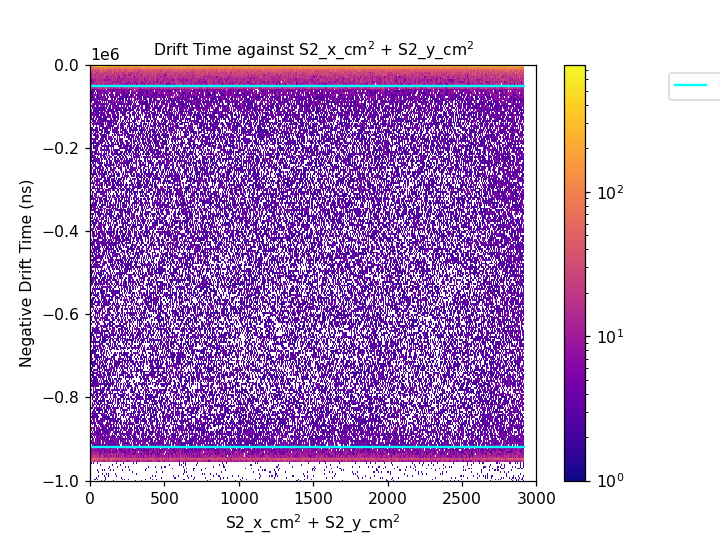

In [63]:
#4. Drift time against S2_x_cm^2 + S2_y_cm^2
#Nothing cut so far
#Note: data points for x>2916 seems to have already been cut for us

x2y2= np.square(arr['S2_x_cm'])+np.square(arr['S2_y_cm'])
negdt=np.multiply(arr['drift_time'],-1)

fig, ax = plt.subplots()
#Straight cut lines
line1 = plt.Line2D((0, 2916), (-0.05e6, -0.05e6), color = 'cyan', label="Cut")
line2 = plt.Line2D((0, 2916), (-0.92e6, -0.92e6), color = 'cyan')

h = ax.hist2d(x2y2,negdt,bins=1000, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlim(0,3000)
plt.ylim(-1e6,0)

ax.add_line(line1)
ax.add_line(line2)

plt.xlabel('S2_x_cm$^{2}$ + S2_y_cm$^{2}$')
plt.ylabel('Negative Drift Time (ns)')
plt.title('Drift Time against S2_x_cm$^{2}$ + S2_y_cm$^{2}$',size=10)
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1))
plt.show()

<IPython.core.display.Javascript object>


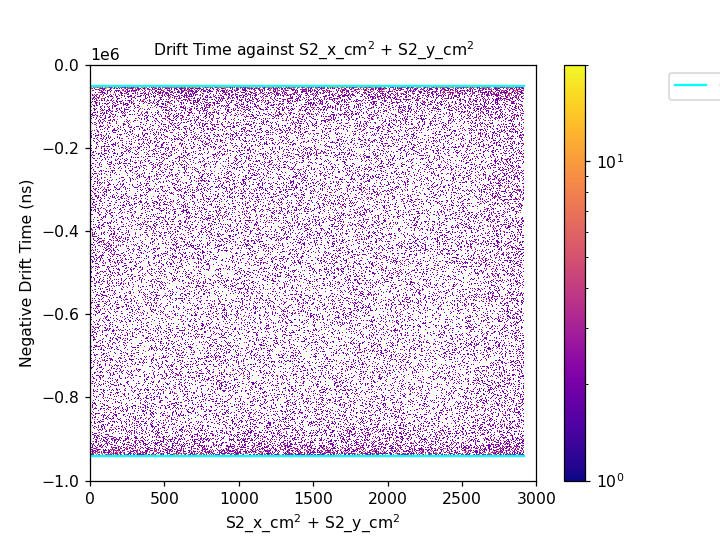

In [64]:
#3 Drift time against S2_x_cm^2 + S2_y_cm^2 WITH cuts
fig, ax = plt.subplots()
conditions= (negdt>-0.94e6) & (negdt<-0.05e6) #Cutting

line1 = plt.Line2D((0, 2916), (-0.05e6, -0.05e6), color = 'cyan', label="Cut")
line2 = plt.Line2D((0, 2916), (-0.94e6, -0.94e6), color = 'cyan')


h = ax.hist2d(x2y2.to_numpy()[conditions],negdt.to_numpy()[conditions],               
              bins=1000, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)
plt.xlim(0,3000)
plt.ylim(-1e6,0)
ax.add_line(line1)
ax.add_line(line2)
plt.xlabel('S2_x_cm$^{2}$ + S2_y_cm$^{2}$')
plt.ylabel('Negative Drift Time (ns)')
plt.title('Drift Time against S2_x_cm$^{2}$ + S2_y_cm$^{2}$',size=10)
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1))
plt.show()

<IPython.core.display.Javascript object>


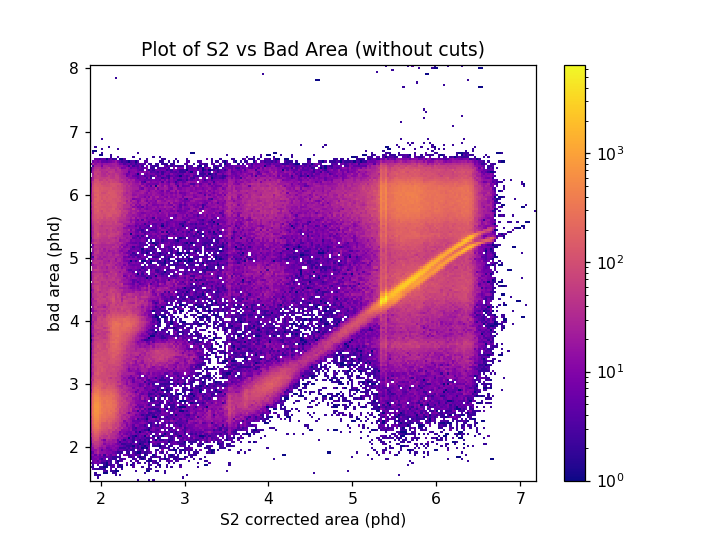

In [65]:
#5. Bad area cut
#nat to log 10
x = np.log10(arr['S2_corrected_area'])
y = np.log10(arr['evt_bad_area'])

fig, ax = plt.subplots()

h = ax.hist2d(x, 
              y,  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)
plt.xlabel('S2 corrected area (phd)')
plt.ylabel('bad area (phd)')
plt.title('Plot of S2 vs Bad Area (without cuts)')
plt.show()

<IPython.core.display.Javascript object>


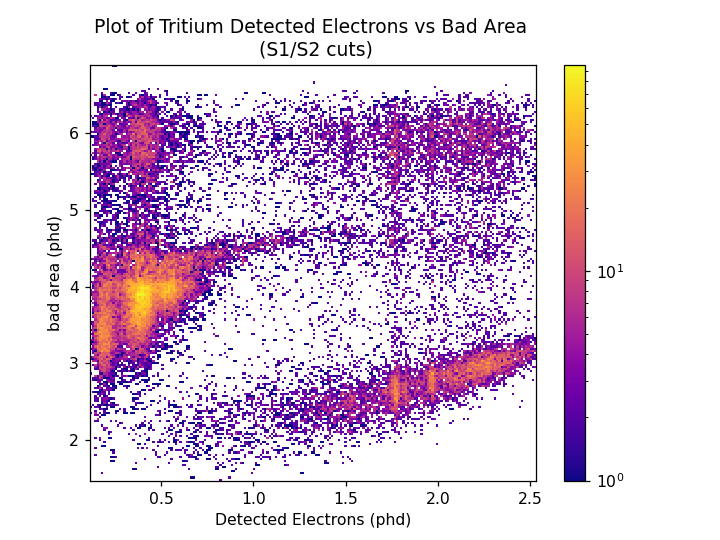

In [68]:
#applying S1 and S2 cuts for tritium 
conditions = (arr['S1_corrected_area']<line(arr['S2_corrected_area'], m, c2)) & (arr['S1_corrected_area']>line(arr['S2_corrected_area'], m, c1)) & (arr['S2_corrected_area']< 20000) & (arr['drift_time']<1e6) & (arr['S2_corrected_area']< 0.5e7)

x = arr['S2_corrected_area'].to_numpy()[conditions]
x = np.log10(x / 58.5)
y = arr['evt_bad_area'].to_numpy()[conditions]
y = np.log10(y)

fig, ax = plt.subplots()

h = ax.hist2d(x, 
              y,  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)
plt.xlabel('Detected Electrons (phd)')
plt.ylabel('bad area (phd)')
plt.title('Plot of Tritium Detected Electrons vs Bad Area \n (S1/S2 cuts)')
plt.show()

<IPython.core.display.Javascript object>


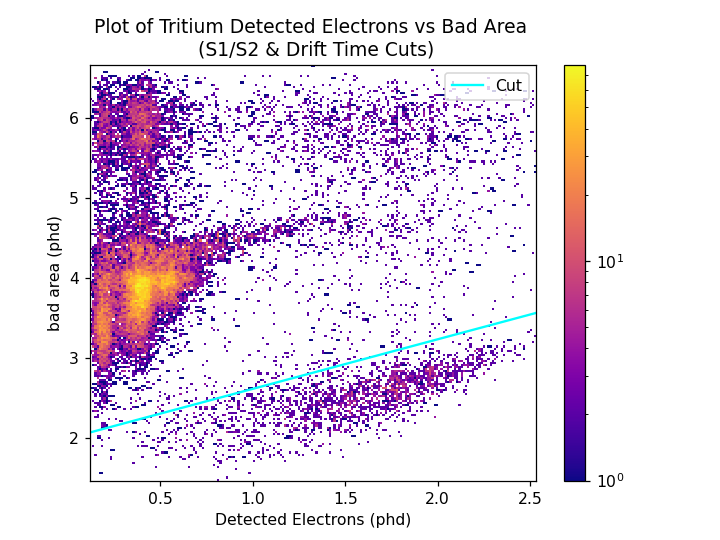

In [90]:
#adding in drift time cut

conditions = (arr['S1_corrected_area']<line(arr['S2_corrected_area'], m, c2)) & (arr['S1_corrected_area']>line(arr['S2_corrected_area'], m, c1)) & (arr['S2_corrected_area']< 20000) & (arr['drift_time']<1e6) & (arr['S2_corrected_area']< 0.5e7) & (negdt>-0.94e6) & (negdt<-0.05e6) 
#(arr['drift_time']> 60000)

x = arr['S2_corrected_area'].to_numpy()[conditions]
x = np.log10(x / 58.5)
y = arr['evt_bad_area'].to_numpy()[conditions]
y = np.log10(y)

fig, ax = plt.subplots()

line1 = plt.Line2D((0, 2.54), (2,3.57), color = 'cyan', label="Cut")

h = ax.hist2d(x, 
              y,  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)

#plt.xlim(0,3)
#plt.ylim(0,7)
plt.xlabel('Detected Electrons (phd)')
plt.ylabel('bad area (phd)')
plt.title('Plot of Tritium Detected Electrons vs Bad Area \n (S1/S2 & Drift Time Cuts)')
ax.add_line(line1)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


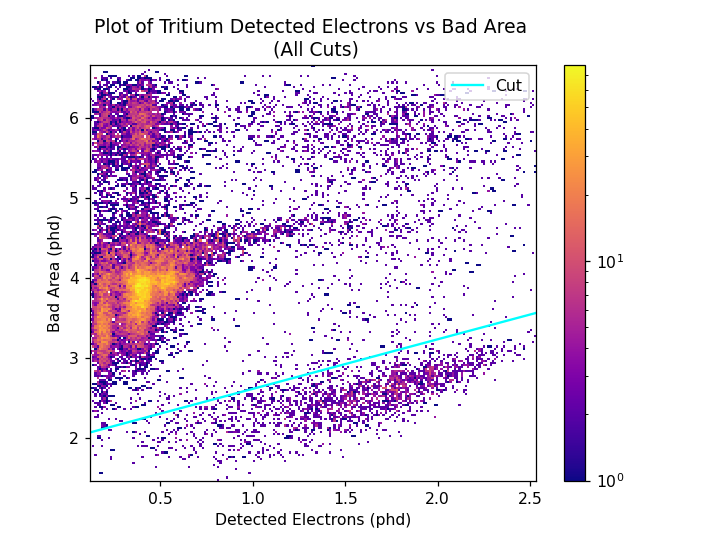

In [93]:
#adding in drift time cut
#need to change drift cut

#(arr['drift_time']> 60000)

conditions = (arr['S1_corrected_area']<line(arr['S2_corrected_area'], m, c2)) & (arr['S1_corrected_area']>line(arr['S2_corrected_area'], m, c1)) & (arr['S2_corrected_area']< 20000) & (arr['drift_time']<1e6) & (arr['S2_corrected_area']< 0.5e7) & (negdt>-0.94e6) & (negdt<-0.05e6) 
x = arr['S2_corrected_area'].to_numpy()[conditions]
x = np.log10(x/58.5)
y = arr['evt_bad_area'].to_numpy()[conditions]
y = np.log10(y)



fig, ax = plt.subplots()

line1 = plt.Line2D((0, 2.54), (2,3.57), color = 'cyan', label="Cut") #why does this line not start at (0,2)?

h = ax.hist2d(x, 
              y,  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)

#plt.xlim(0,3)
#plt.ylim(0,7)
plt.xlabel('Detected Electrons (phd)')
plt.ylabel('Bad Area (phd)')
plt.title('Plot of Tritium Detected Electrons vs Bad Area \n (All Cuts)')
ax.add_line(line1)
plt.legend()
plt.show()

## Gate/cathode-like events

1. Plot background S2 width (AFT 90 - AFT 10) vs drift time, select gate (or gate + gas) events and cathode events
<br> Apply bad area cut from above and  threshold cut to 1


Bg 1 = gas and gate (left hand side)
<br> 
Bg 2 = Cathode (right hand side)
<br> 
Bg 3 = Other bacgkround (events in the center)
<br>
<br>
2. Consider an S1 vs S2 cut

In [49]:
with uproot.open("bg_sr1_fixed.root") as f:
    bg = f["Events"].arrays(cut = 'S1_corrected_area > 0', library = 'pd')
bg.head()
bg.keys()

Index(['runID', 'evtID', 'S2_area', 'S2_btm_area', 'S2_top_area', 'S2_TBA',
       'S2_corrected_area', 'S2_XY_corrected_area', 'S2_width_ns',
       'S2_peakAmp', 'S2_AFT_5', 'S2_AFT_10', 'S2_AFT_25', 'S2_AFT_50',
       'S2_AFT_75', 'S2_AFT_90', 'S2_AFT_95', 'S2_rmsWidth_ns', 'S2_fwhm_ns',
       'S2_x_cm', 'S2_y_cm', 'S2_xy_chiSq', 'S2_n_saturated', 'has_good_S1',
       'drift_time', 'S1_area', 'S1_corrected_area', 'evt_total_area',
       'evt_bad_area', 'evt_bad_e_area', 'evt_bad_ph_area',
       'evt_bad_oth_area'],
      dtype='object')

<IPython.core.display.Javascript object>


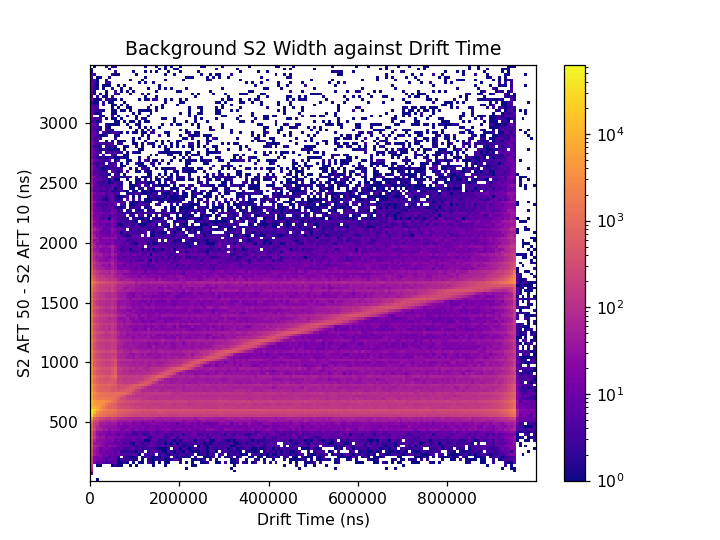

Text(0.5, 1.0, 'Background S2 Width against Drift Time')

In [57]:
#1. Plot background date width vs drift
fig, ax = plt.subplots()
y=bg['S2_AFT_50']-bg['S2_AFT_10']
conditions= (bg['drift_time']<1e6) & (y<3500)

h = ax.hist2d(bg['drift_time'].to_numpy()[conditions],y.to_numpy()[conditions],
              bins=150,cmap = mpl.colormaps['plasma'],norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('Drift Time (ns)')
plt.ylabel('S2 AFT 50 - S2 AFT 10 (ns)')
plt.title('Background S2 Width against Drift Time')

<IPython.core.display.Javascript object>


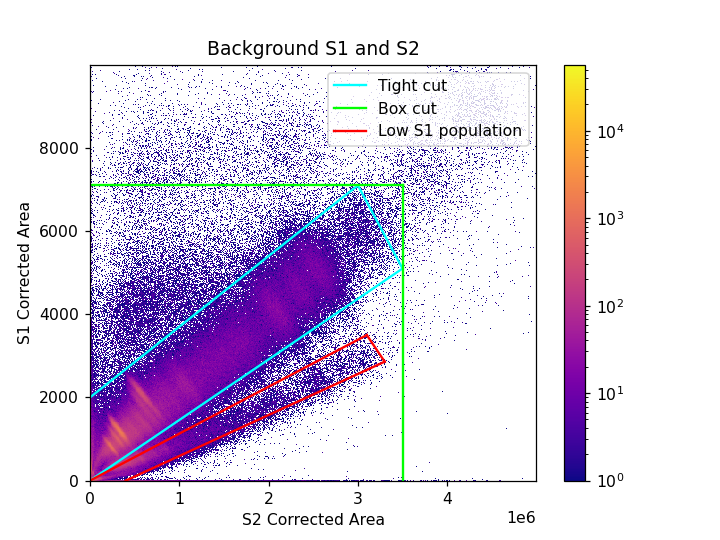

In [20]:
#2. Background S1 against S2 plot
fig, ax = plt.subplots()
conditions= (bg['S1_corrected_area']<10000) & (bg['S2_corrected_area']<5e6)

#Tight cut
line1 = plt.Line2D((0,3e6), (2000,7100), color = 'cyan', label="Tight cut")
line2 = plt.Line2D((0,3.5e6), (0,5100), color = 'cyan')
line3 = plt.Line2D((3e6,3.5e6), (7100, 5100), color = 'cyan')


#Box cut
line4=plt.Line2D((0,3.5e6),(7100,7100), color="lime", label = "Box cut")
line5 = plt.Line2D((3.5e6, 3.5e6), (0, 7100), color = 'lime')

#Low S1 population
line6=plt.Line2D((0,3.1e6),(0,3500), color="red", label = "Low S1 population")
line7 = plt.Line2D((4e5, 3.3e6), (0,2860), color = 'red')
line8 = plt.Line2D((3.1e6, 3.3e6), (3500,2860), color = 'red')


h = ax.hist2d(bg['S2_corrected_area'].to_numpy()[conditions],bg['S1_corrected_area'].to_numpy()[conditions],
              bins=500,cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

ax.add_line(line1)
ax.add_line(line2)
ax.add_line(line3)

ax.add_line(line4)
ax.add_line(line5)

ax.add_line(line6)
ax.add_line(line7)
ax.add_line(line8)

plt.xlabel('S2 Corrected Area')
plt.ylabel('S1 Corrected Area')
plt.title('Background S1 and S2')
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


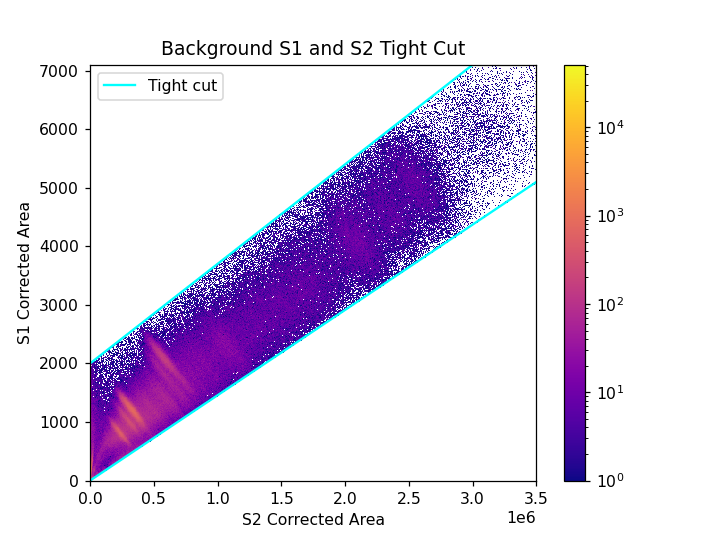

In [15]:
#2. Background S1 against S2 plot
#TIGHT CUT
fig, ax = plt.subplots()


#Tight cut
line1 = plt.Line2D((0,3e6), (2000,7100), color = 'cyan', label="Tight cut")
line2 = plt.Line2D((0,3.5e6), (0,5100), color = 'cyan')
line3 = plt.Line2D((3e6,3.5e6), (7100, 5100), color = 'cyan')
m=0.0017
c1=2000
c2=-0.0006

#Box cut
line4=plt.Line2D((0,3.5e6),(7100,7100), color="lime", label = "Box cut")
line5 = plt.Line2D((3.5e6, 3.5e6), (0, 7100), color = 'lime')

#Low S1 population
line6=plt.Line2D((0,3.1e6),(0,3500), color="red", label = "Low S1 population")
line7 = plt.Line2D((4e5, 3.3e6), (0,2860), color = 'red')
line8 = plt.Line2D((3.1e6, 3.3e6), (3500,2860), color = 'red')


conditions = (bg['S1_corrected_area']<line(bg['S2_corrected_area'], m, c1)) & (bg['S1_corrected_area']>line(bg['S2_corrected_area'], 0.00145, c2))  & (bg['S2_corrected_area']< 3.5e6) &(bg['S1_corrected_area']<7100) 
h = ax.hist2d(bg['S2_corrected_area'].to_numpy()[conditions],bg['S1_corrected_area'].to_numpy()[conditions],
              bins=500,cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

ax.add_line(line1)
ax.add_line(line2)
#ax.add_line(line3)



plt.xlim(0,3.5e6)
plt.ylim(0,7100)
plt.xlabel('S2 Corrected Area')
plt.ylabel('S1 Corrected Area')
plt.title('Background S1 and S2 Tight Cut')
plt.legend(loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


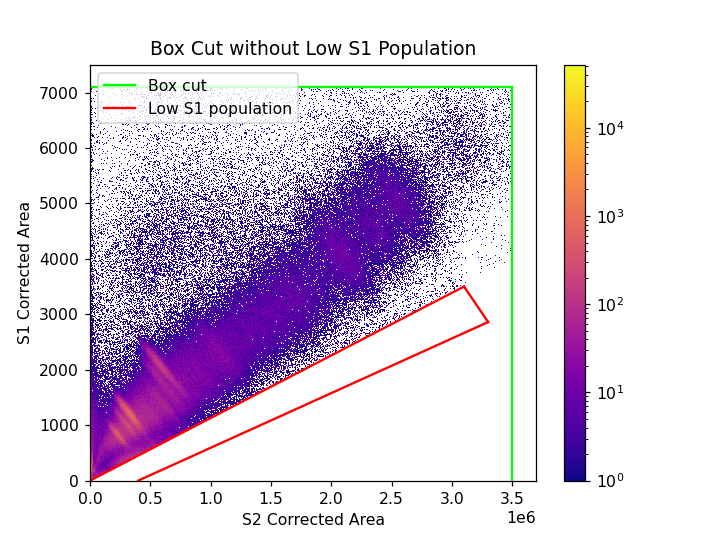

In [16]:
#2. Background S1 against S2 plot
#BOX CUT WITHOUT LOW S1 POPULATION
fig, ax = plt.subplots()

#Box cut
line4=plt.Line2D((0,3.5e6),(7100,7100), color="lime", label = "Box cut")
line5 = plt.Line2D((3.5e6, 3.5e6), (0, 7100), color = 'lime')

#Low S1 population
line6=plt.Line2D((0,3.1e6),(0,3500), color="red", label = "Low S1 population")
line7 = plt.Line2D((4e5, 3.3e6), (0,2860), color = 'red')
line8 = plt.Line2D((3.1e6, 3.3e6), (3500,2860), color = 'red')
m=0.00114
c1=0
c2=-50

conditions =(bg['S1_corrected_area']>line(bg['S2_corrected_area'], m, c1))  & (bg['S2_corrected_area']< 3.5e6) &(bg['S1_corrected_area']<7100) 

h = ax.hist2d(bg['S2_corrected_area'].to_numpy()[conditions],bg['S1_corrected_area'].to_numpy()[conditions],
              bins=500,cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

ax.add_line(line4)
ax.add_line(line5)

ax.add_line(line6)
ax.add_line(line7)
ax.add_line(line8)

plt.xlim(0,3.7e6)
plt.ylim(0,7500)
plt.xlabel('S2 Corrected Area')
plt.ylabel('S1 Corrected Area')
plt.title('Box Cut without Low S1 Population')
plt.legend(loc='upper left')
plt.show()